## Basic Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from fastai.vision import *
from pathlib import Path
from utils import *
from tqdm import tqdm, tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
import cv2

matplotlib.style.use('fivethirtyeight')

In [2]:
%%capture
learn = load_learner('/home/rahul/github_projects/shot-type-classifier/models/', file='shot-type-classifier.pkl');

In [3]:
path = Path('/home/rahul/Desktop/movies/the-social-network-splits/')

## Reading in Video with `cv2` and Predicting Shot Type 

Somehow, when reading in videos with `cv2`, the last 5 frames always get skipped.

### OpenCV Properties Key 

0. `CV_CAP_PROP_POS_MSEC` Current position of the video file in milliseconds.
1. `CV_CAP_PROP_POS_FRAMES` 0-based index of the frame to be decoded/captured next.
2. `CV_CAP_PROP_POS_AVI_RATIO` Relative position of the video file
3. `CV_CAP_PROP_FRAME_WIDTH` Width of the frames in the video stream.
4. `CV_CAP_PROP_FRAME_HEIGHT` Height of the frames in the video stream.
5. `CV_CAP_PROP_FPS` Frame rate.
6. `CV_CAP_PROP_FOURCC` 4-character code of codec.
7. `CV_CAP_PROP_FRAME_COUNT` Number of frames in the video file.
8. `CV_CAP_PROP_FORMAT` Format of the Mat objects returned by retrieve() .
9. `CV_CAP_PROP_MODE` Backend-specific value indicating the current capture mode.
10. `CV_CAP_PROP_BRIGHTNESS` Brightness of the image (only for cameras).
11. `CV_CAP_PROP_CONTRAST` Contrast of the image (only for cameras).
12. `CV_CAP_PROP_SATURATION` Saturation of the image (only for cameras).
13. `CV_CAP_PROP_HUE` Hue of the image (only for cameras).
14. `CV_CAP_PROP_GAIN` Gain of the image (only for cameras).
15. `CV_CAP_PROP_EXPOSURE` Exposure (only for cameras).
16. `CV_CAP_PROP_CONVERT_RGB` Boolean flags indicating whether images should be converted to RGB.
17. `CV_CAP_PROP_WHITE_BALANCE` Currently unsupported
18. `CV_CAP_PROP_RECTIFICATION` Rectification flag for stereo cameras (note: only supported by DC1394 v 2.x backend currently)

### Frame Grabbing Function

In [4]:
from fastai.vision import *

get_fps     = lambda fname: cv2.VideoCapture(fname).get(cv2.CAP_PROP_FPS)
get_nframes = lambda fname: int(cv2.VideoCapture(fname).get(cv2.CAP_PROP_FRAME_COUNT))
to_tensor   = lambda x: pil2tensor(x, np.float32).div_(255)
to_img      = lambda x: Image(pil2tensor(x, np.float32).div_(255))

def grab_frames(fname, frames, ret_type='fastai'):
    '''
    Doc goes here hehe...
    '''
    # essential checks
    assert ret_type in ['np', 'fastai', 'tensor'], 'Choose either \'np\',  \'fastai\' or \'tensor\' as your return type'
    assert isinstance(frames, (tuple, list, int)), '`frames` must be either a tuple, list, or int'
    
    # prep video
    fps, num_frames = get_fps(fname), get_nframes(fname)

    # get frame indices (targets) for video
    if   isinstance(frames, tuple) : target_frames = np.arange(*frames)
    elif isinstance(frames, list)  : target_frames = frames
    elif isinstance(frames, int)   : target_frames = [frames]

    # grab the targeted frames
    grabbed=[]
    for i in target_frames:
        cap = cv2.VideoCapture(fname)
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret==True: grabbed.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # return np.array
        else: break
    cap.release()
    
    # optionally return fastai.vision.image.Image for convenience
    # this allows you to run `learn.predict()` and view the image directly. 
    if ret_type == 'fastai': grabbed = [to_img(x) for x in grabbed]
    if ret_type == 'tensor': grabbed = torch.stack([to_tensor(x) for x in grabbed])
    
    return grabbed, target_frames, (fname, fps, num_frames)


### Predict Function

In [5]:
get_shot_idx  = lambda path: int(
    str(path)            ## /home/...../shot#0002.mp4
        .rsplit('/')[-1] ## shot#0002.mp4
        .split('.')[0]   ## shot#0002
        .split('#')[-1]  ## 0002 --> 2
)

# f = str(path/'shot#0002.mp4')
# get_shot_idx(f)
# get_shot_idx(os.listdir(path)[0])

def get_key_pred(df):
    i = df.groupby(['shot_no'])['prediction'].transform(max) == df['prediction']
    return df[i]

def predict(frame, frame_idx, fname, fps, num_frames):
    classes = ['Close-Up', 'Extreme Close-Up', 'Extreme Wide', 'Long', 'Medium', 'Medium Close-Up']
    shot_idx = get_shot_idx(fname)

    # get preds
    pred, _, pred_ps = learn.predict(frame)

    # form data-frame
    df = pd.DataFrame(list(zip(classes, pred_ps.numpy())), columns=['shot_type', 'prediction'])

    # replace shot-types with acronyms
    df['shot_type'].replace({    'Extreme Wide': 'EWS',
                                         'Long': 'LS',
                                       'Medium': 'MS',
                              'Medium Close-Up': 'MCU',
                                     'Close-Up': 'CU',
                             'Extreme Close-Up': 'ECU'}, inplace=True)
    # set sorting order for shot-types and sort
    df['shot_type'] = pd.Categorical(df['shot_type'], ['EWS', 'LS', 'MS', 'MCU', 'CU', 'ECU'])
    df = df.sort_values('shot_type').reset_index(drop=True)

    # add more info
    df['prediction'] *= 100
    df['frame_no']    = frame_idx+1
    df['shot_no']     = shot_idx
    df['shot_length'] = num_frames / get_fps(fname)
    
    #print(f'Shot #{shot_idx:04d}, Frame #{frame_idx+1:04d}: {pred}')
    return df, get_key_pred(df)

### Getting Predictions for All Files In a Directory

In [4]:
movie_path = '/home/home/rahul/Desktop//Desktop/movies/the-social-network.mkv'
movie_name = movie_path.split('/')[-1].split('.')[0]
movie_name

'the-social-network'

In [54]:
preds_key = pd.read_csv(path/'preds-key.csv') if Path.exists(path/'preds-key.csv') else []
preds_all = pd.read_csv(path/'preds-all.csv') if Path.exists(path/'preds-all.csv') else []

os.chdir(path)
fnames = [f for f in sorted(os.listdir(path)) if f.endswith('.mp4')]

for fname in tqdm_notebook(fnames[2200:]):
    # prep video and its properties
    frame_stride  = 6
    target_frames = (0, get_nframes(fname), frame_stride)  
    frames, target_frames, info  = grab_frames(fname, target_frames)

    # get predictions with multiple levels of info
    for i,frame in zip(target_frames,frames):
        preds_i, pred_i = predict(frame, i, *info)
        
        # why doesn't this work as a function?
        if isinstance(preds_key, list): preds_key.append(pred_i)
        else: preds_key = pd.concat([preds_key, pred_i])
            
        if isinstance(preds_all, list): preds_all.append(preds_i)
        else: preds_all = pd.concat([preds_all, preds_i])
    
    if isinstance(preds_key, list): preds_key = pd.concat(preds_key, ignore_index=True)
    if isinstance(preds_all, list): preds_all = pd.concat(preds_all, ignore_index=True)

    preds_key.drop_duplicates().to_csv(path/'preds-key.csv', index=False)
    preds_all.drop_duplicates().to_csv(path/'preds-all.csv', index=False)


In [56]:
type(learn)

fastai.basic_train.Learner

In [57]:
order = lambda df: df.sort_values(['shot_no', 'frame_no'])
order(preds_key)

,shot_type,prediction,frame_no,shot_no,shot_length
0,EWS,92.825830,1,1,30.739042
1,EWS,93.818545,7,1,30.739042
2,EWS,95.311713,13,1,30.739042
3,EWS,92.505276,19,1,30.739042
4,EWS,90.770406,25,1,30.739042
...,...,...,...,...,...
4,CU,99.936980,205,2296,9.634625
4,CU,99.969363,211,2296,9.634625
4,CU,99.965477,217,2296,9.634625
4,CU,99.925834,223,2296,9.634625


## Analysing Predictions using `R`

In [101]:
%load_ext rpy2.ipython

In [103]:
preds_key = pd.read_csv('preds-key.csv')

In [109]:
%%R -i preds_key

library(tidyverse)
library(data.table)

df <- read_csv('preds-key.csv')

## shots that have more than 1 predicted shot-type for its frames
## regardless of confidence of the predictions
shot_idxs <-
    df %>%
    group_by  (shot_no) %>%
    summarise (num=n_distinct(shot_type)) %>%
    filter    (num > 1) %>%
    .$shot_no

inspect_shot_df   <- map_df(shot_idxs, function(i) df %>% filter(shot_no == i))
inspect_shot_list <- inspect_shot_df %>% split(., .$shot_no)

filter_confident <- function(df, confidence=80)
    df %>% group_by(shot_no) %>% filter(prediction > confidence)

filter_unconfident <- function(df, confidence=80)
    df %>% group_by(shot_no) %>% filter(prediction < confidence)

## shots that you're confident have more than 1 shot type
shot_idxs <-
    inspect_shot_df %>%
    filter_confident %>%
    summarise (num=n_distinct(shot_type)) %>%
    filter    (num > 1) %>%
    .$shot_no

inspect_shot_df   <- map_df(shot_idxs, function(i) df %>% filter(shot_no == i))
inspect_shot_list <- inspect_shot_df %>% split(., .$shot_no)

## shots that you're 100% sure of have the same shot type for each frame
idxs_confident <-
    df %>%
    filter(!shot_no %in% shot_idxs) %>%
    filter_confident %>%
    .$shot_no %>% unique

shot_list_confident <-
    df %>%
    filter_confident %>%
    #filter(shot_no %in% idxs_confident) %>%
    split(., .$shot_no) %>%
    map_df(., function(df) {
        tibble(shot_no     = unique(df$shot_no),
               shot_type   = unique(df$shot_type),
               shot_length = unique(df$shot_length))
    })
write.csv(shot_list_confident, 'shot-list-confident.csv', row.names=FALSE)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ stringr 1.4.0
✔ tidyr   1.0.0     ✔ forcats 0.4.0
✔ readr   1.3.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::filter()       masks stats::filter()
✖ data.table::first()   masks dplyr::first()
✖ dplyr::lag()          masks stats::lag()
✖ data.table::last()    masks dplyr::last()
✖ purrr::transpose()    masks data.table::transpose()

R[write to console]: Parsed with column specification:
cols(
  shot_type = col_character(),
  prediction = col_double(),
  frame_no = col_double(),
  shot_no = col_double(),
  shot_length = col_double()
)



## Interactive Visualisation

In [113]:
path

PosixPath('/home/rahul/Desktop/movies/the-social-network-splits')

In [114]:
shot_list = pd.read_csv(path/'shot-list-confident.csv')
shot_list

,shot_no,shot_type,shot_length
0,1,EWS,30.739042
1,1,MS,30.739042
2,1,LS,30.739042
3,2,MCU,2.085417
4,3,MCU,2.335667
...,...,...,...
2305,2293,MCU,20.478792
2306,2293,CU,20.478792
2307,2294,ECU,2.293958
2308,2295,ECU,2.419083


### Matplotlib

/home/rahul/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


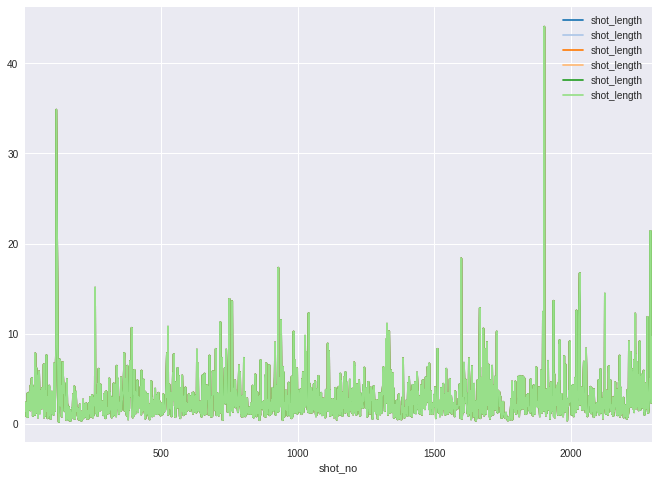

In [33]:
# https://nipunbatra.github.io/blog/2017/50-ggplot-python-1.html
colors = [(31, 119, 180),  (174, 199, 232), (255, 127, 14),  (255, 187, 120),  
          (44, 160, 44),   (152, 223, 138), (214, 39, 40),   (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75),   (196, 156, 148),  
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
          (188, 189, 34),  (219, 219, 141), (23, 190, 207),  (158, 218, 229)]

colors = [(r/255., g/255., b/255.) for r,g,b in colors]

matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
for i, (name, group) in enumerate(shot_list.groupby('shot_type')):
    shot_list.plot(x='shot_no',y='shot_length', figsize=(10,8), ax=ax, colors=colors[i])

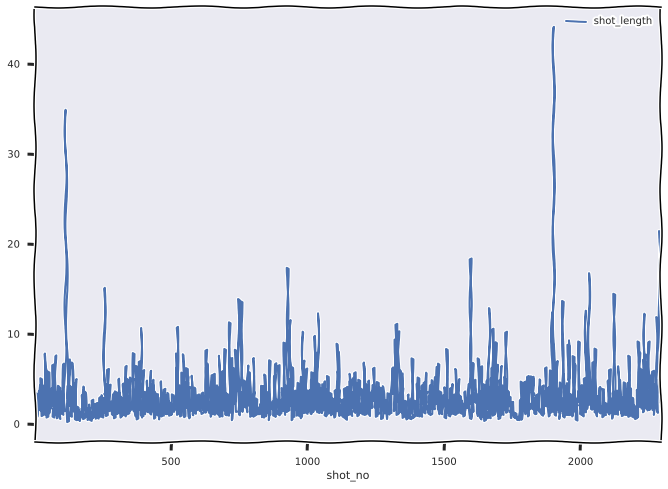

In [16]:
with plt.xkcd():
    shot_list.plot(x='shot_no',y='shot_length', figsize=(10,8))

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


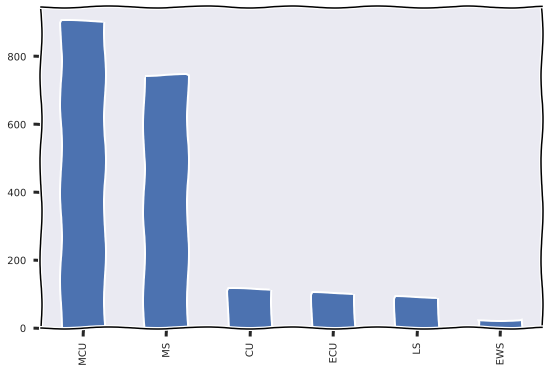

In [92]:
with plt.xkcd():
    shot_list['shot_type'].value_counts().plot(kind='bar')

### Altair (Interactive) -- waaaaaay better than `matplotlib`

RendererRegistry.enable('notebook')

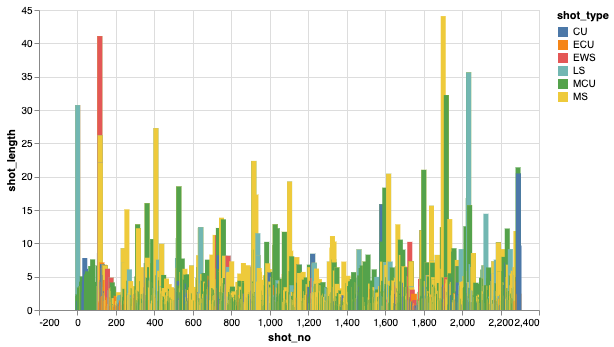

In [115]:
import altair as alt
from altair import Chart
alt.renderers.enable('notebook')

base = Chart(shot_list) \
    .mark_bar() \
    .encode(x='shot_no', y='shot_length', color='shot_type') \
    .properties(width=500) \
    .interactive(bind_y=False)
base

#brush = alt.selection_interval(encodings=['x'],empty='all')
#background = base.add_selection(brush)
#selected = base.transform_filter(brush).mark_bar()

#background.interactive(bind_y=False)# + selected